# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
#STATION_IDS = [211, 212, 213, 214, 215, 216]
#STATION_IDS = [211, 212, 213, 214, 216]
STATION_IDS = [211, 212, 213, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "SO2_quantrac",
    #"Temperature_quantrac",
    #"Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]
#LAG_STEPS = [3, 6, 12, 24, 48, 72]
#ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_19-22_14_21


# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(61139, 7)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,NaN,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,NaN,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,NaN,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,NaN,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,NaN,211
...,...,...,...,...,...,...,...
61134,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,0.105667,216
61135,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,0.104167,216
61136,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,0.130167,216
61137,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,0.075833,216


In [3]:
df_all.isnull().sum()

date                 0
NO2_quantrac     30980
PM25_quantrac    30335
O3_quantrac      30979
CO_quantrac      31033
SO2_quantrac     53235
station_id           0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2022-01-01 00:00:00,0.068981,18.414899,51.895318,1.238117,0.088139,216
1,2022-01-01 01:00:00,0.069400,19.490000,54.933333,0.930000,0.065333,216
2,2022-01-01 02:00:00,0.068500,18.080000,55.033333,0.788667,0.053167,216
3,2022-01-01 03:00:00,0.069683,16.393333,55.700000,0.732667,0.045167,216
4,2022-01-01 04:00:00,0.069417,15.293333,55.916667,0.717833,0.044500,216
...,...,...,...,...,...,...,...
7897,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,0.105667,216
7898,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,0.104167,216
7899,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,0.130167,216
7900,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,0.075833,216


## Update the STATION_IDS after dropping missing

In [5]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[216]

## Visualization

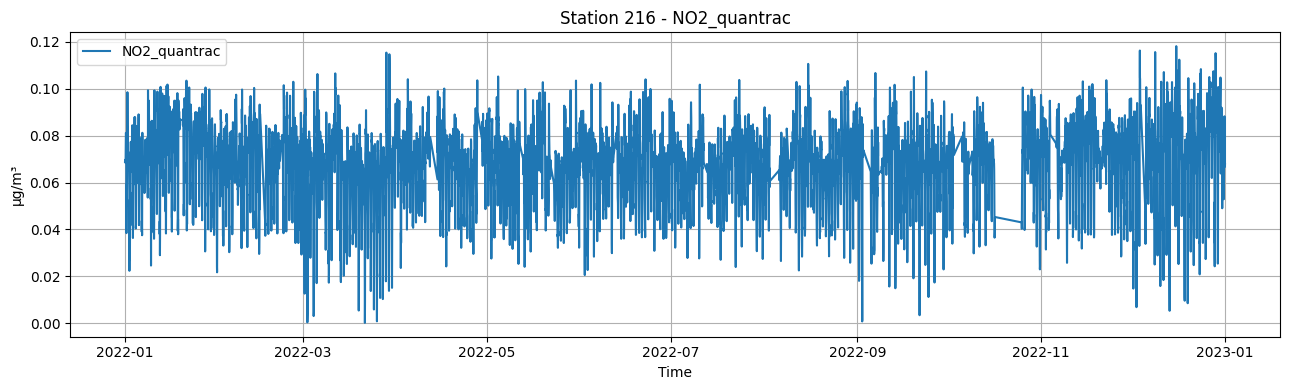

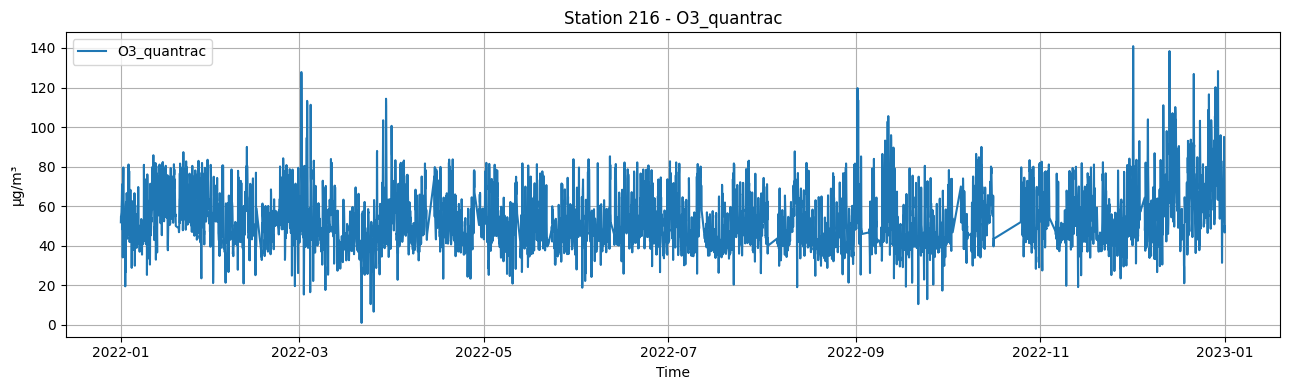

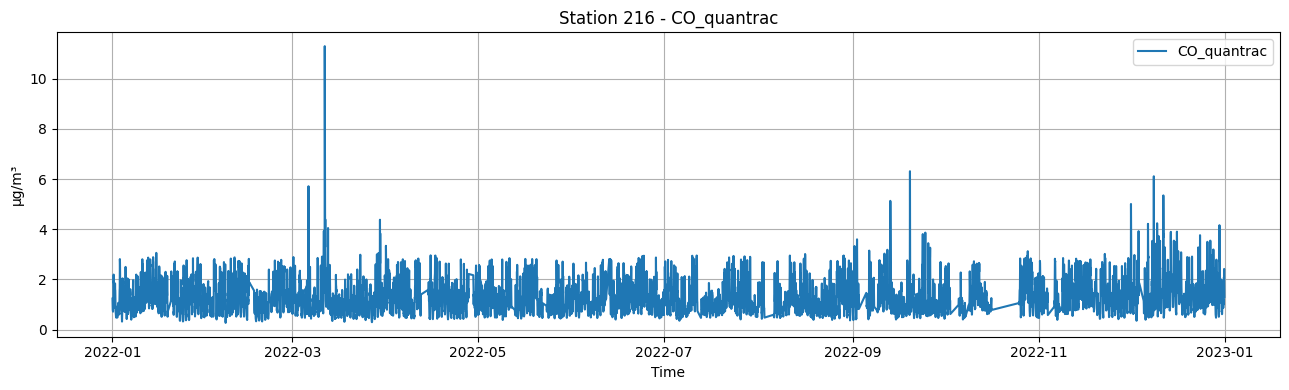

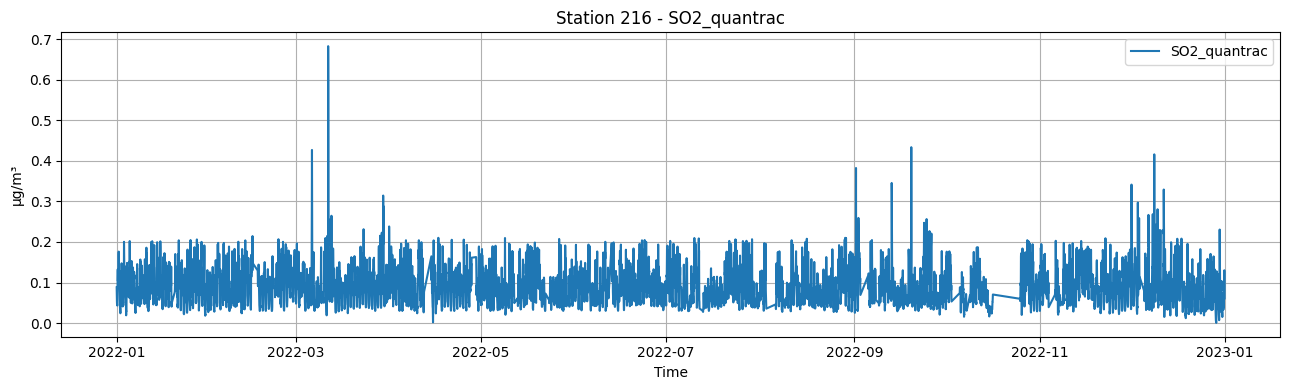

In [6]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [7]:
df_converted = copy.deepcopy(df_dropped)
#mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")

print("=" * 50 + "BEFORE" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

#mask_no2 = (df_converted["NO2_quantrac"] < 1.0)
#df_converted.loc[mask_no2, "NO2_quantrac"] = df_converted.loc[mask_no2, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "NO2_quantrac"] = df_converted.loc[:, "NO2_quantrac"].apply(lambda x: x * 1883.2)

#mask_co = (df_converted["CO_quantrac"] < 1.0)
#df_converted.loc[mask_co, "CO_quantrac"] = df_converted.loc[mask_co, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[:, "CO_quantrac"] = df_converted.loc[:, "CO_quantrac"].apply(lambda x: x * 1146.8)

#mask_so2 = (df_converted["SO2_quantrac"] < 1.0)
#df_converted.loc[mask_so2, "SO2_quantrac"] = df_converted.loc[mask_so2, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted.loc[:, "SO2_quantrac"] = df_converted.loc[:, "SO2_quantrac"].apply(lambda x: x * 2620)

print("=" * 50 + "AFTER" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

==================================================BEFORE==================================================


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2022-01-01 00:00:00,0.068981,18.414899,51.895318,1.238117,0.088139,216
1,2022-01-01 01:00:00,0.069400,19.490000,54.933333,0.930000,0.065333,216
2,2022-01-01 02:00:00,0.068500,18.080000,55.033333,0.788667,0.053167,216
3,2022-01-01 03:00:00,0.069683,16.393333,55.700000,0.732667,0.045167,216
4,2022-01-01 04:00:00,0.069417,15.293333,55.916667,0.717833,0.044500,216
...,...,...,...,...,...,...,...
7897,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,0.105667,216
7898,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,0.104167,216
7899,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,0.130167,216
7900,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,0.075833,216


==================================================AFTER==================================================


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2022-01-01 00:00:00,129.905143,18.414899,51.895318,1419.872305,230.924024,216
1,2022-01-01 01:00:00,130.694080,19.490000,54.933333,1066.524000,171.173333,216
2,2022-01-01 02:00:00,128.999200,18.080000,55.033333,904.442933,139.296667,216
3,2022-01-01 03:00:00,131.227653,16.393333,55.700000,840.222133,118.336667,216
4,2022-01-01 04:00:00,130.725467,15.293333,55.916667,823.211267,116.590000,216
...,...,...,...,...,...,...,...
7897,2022-12-31 19:00:00,166.161013,41.450000,75.916667,2393.562733,276.846667,216
7898,2022-12-31 20:00:00,156.713627,50.530000,66.116667,2301.054200,272.916667,216
7899,2022-12-31 21:00:00,158.753760,55.055000,55.133333,2773.918067,341.036667,216
7900,2022-12-31 22:00:00,125.515280,26.078333,46.750000,1698.984200,198.683333,216


## Visualization after converting unit

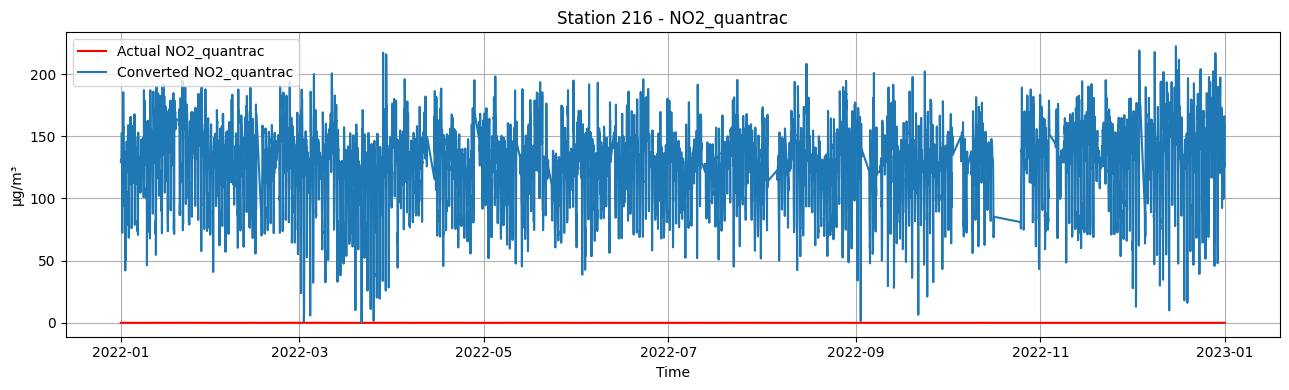

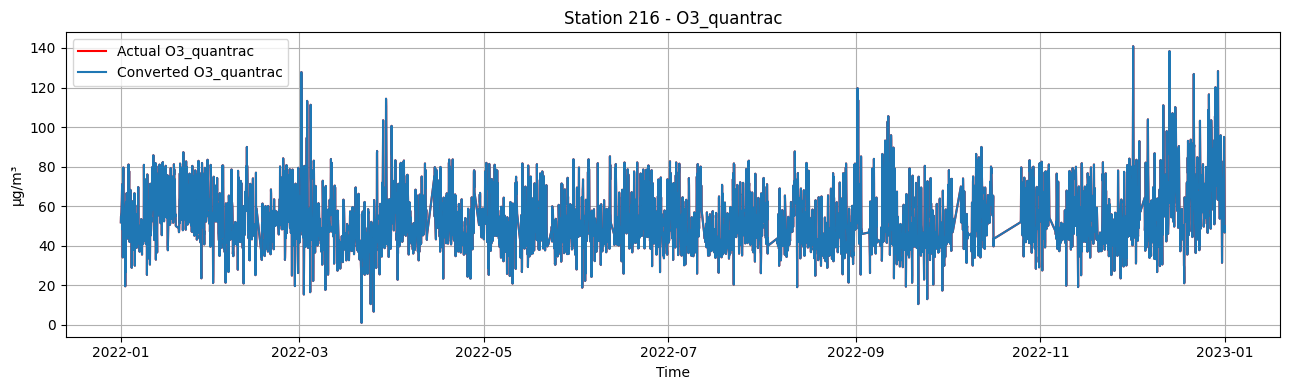

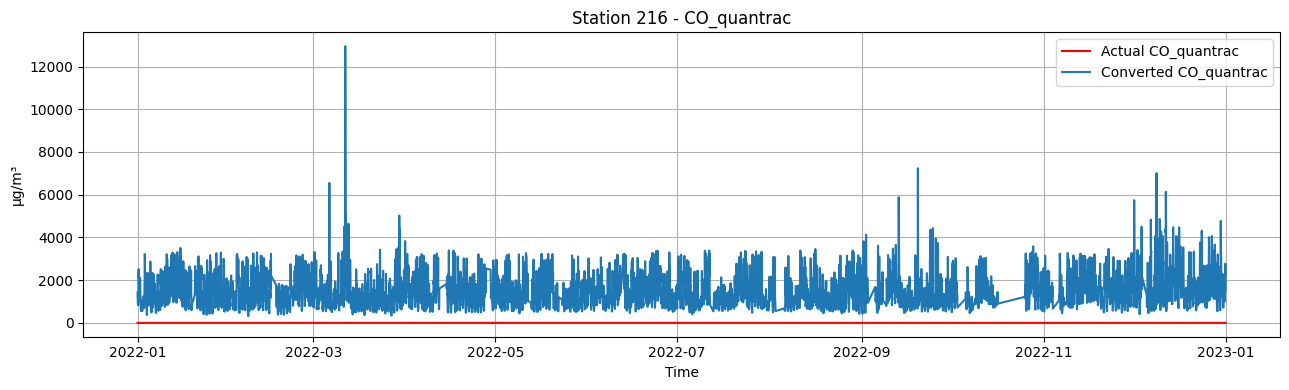

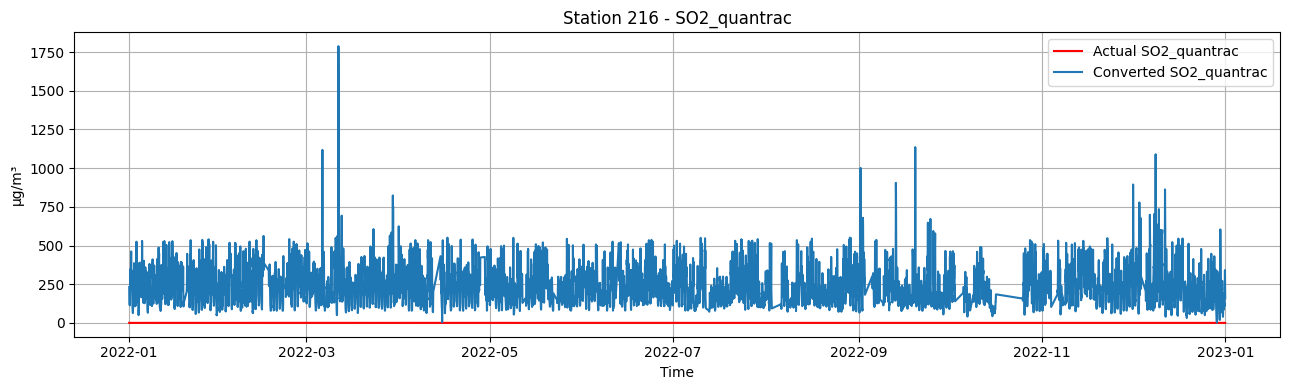

In [8]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [9]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 214 SO2 quantrac
#test214 = test[test["station_id"] == 214]
#test = test.drop(index=test214[test214["SO2_quantrac"] > 120].index, errors="ignore")
#test = test.drop(index=test214[test214["O3_quantrac"] > 80].index, errors="ignore")

# 216 SO2 quantrac
test216 = test[test["station_id"] == 216]
#test = test.drop(index=test216[test216["SO2_quantrac"] > 700].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_quantrac"] > 500].index, errors="ignore")
test = test.drop(index=test216[test216["O3_quantrac"] > 120].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 7902 records
After: 7711 records
Removed 191 records


## Visualization after removing outliers

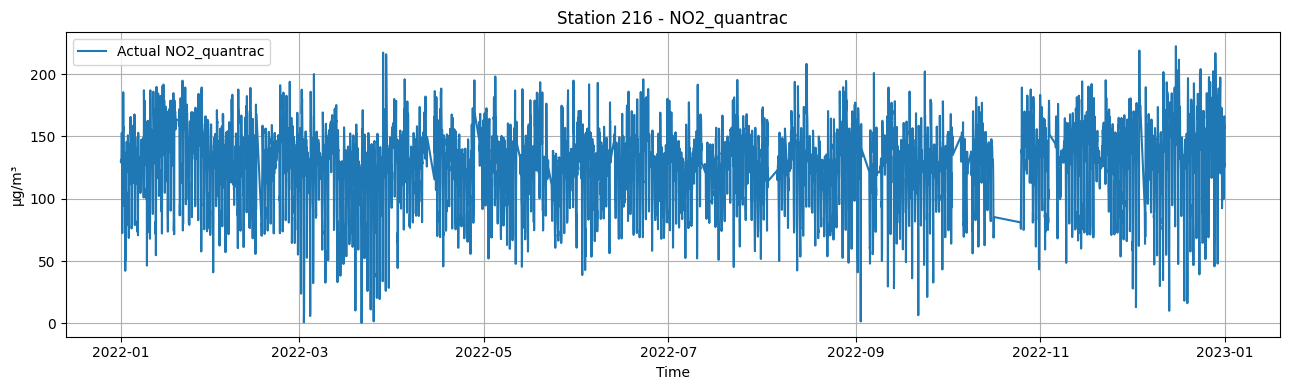

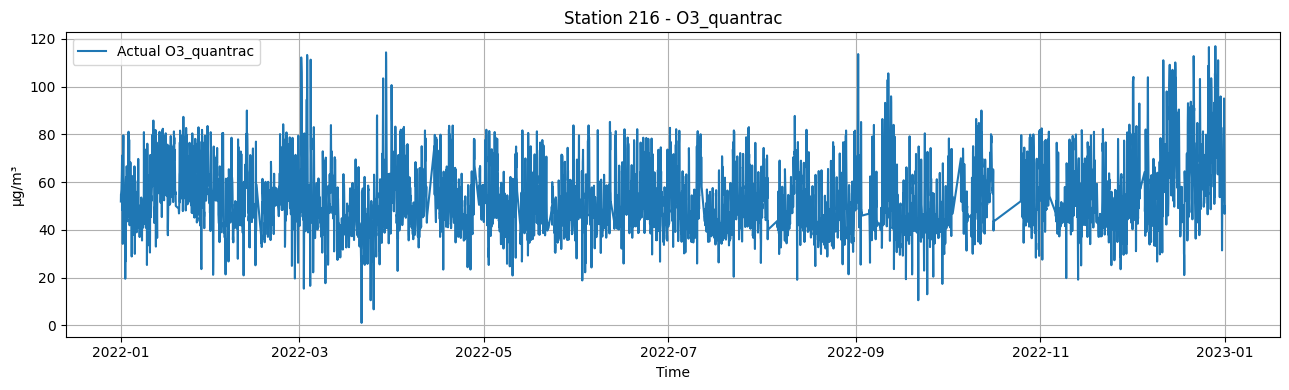

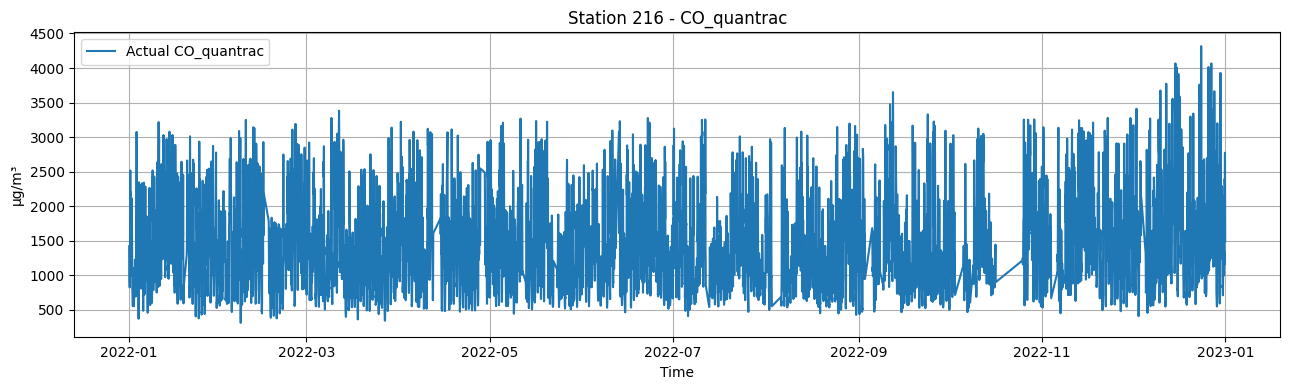

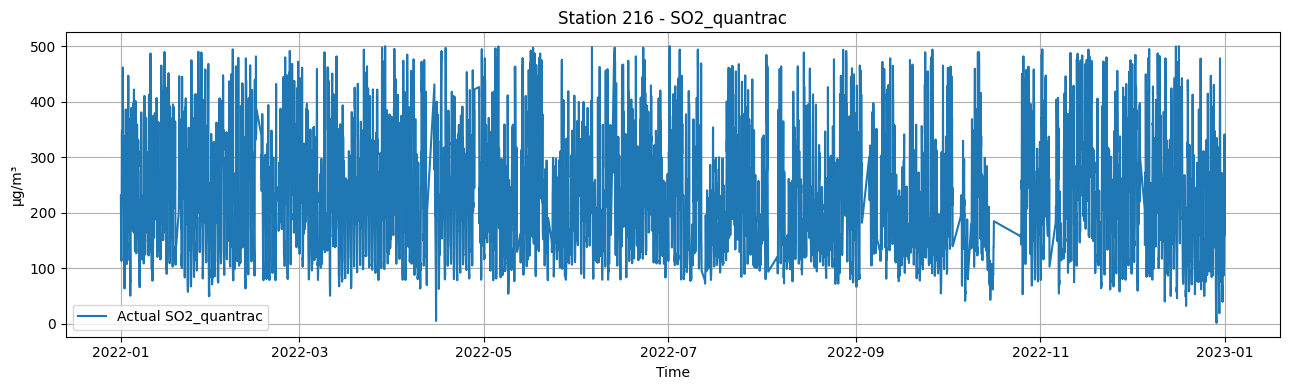

In [10]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [11]:
# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO2_quantrac"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(7711, 15)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id', 'NO2_quantrac_roll3_mean',
       'NO2_quantrac_roll3_std', 'NO2_quantrac_roll6_mean',
       'NO2_quantrac_roll6_std', 'NO2_quantrac_roll12_mean',
       'NO2_quantrac_roll12_std', 'NO2_quantrac_roll24_mean',
       'NO2_quantrac_roll24_std'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 00:00:00,129.905143,18.414899,51.895318,1419.872305,230.924024,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 01:00:00,130.694080,19.490000,54.933333,1066.524000,171.173333,216,129.905143,NaN,129.905143,NaN,129.905143,NaN,129.905143,NaN
2,2022-01-01 02:00:00,128.999200,18.080000,55.033333,904.442933,139.296667,216,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862
3,2022-01-01 03:00:00,131.227653,16.393333,55.700000,840.222133,118.336667,216,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113
4,2022-01-01 04:00:00,130.725467,15.293333,55.916667,823.211267,116.590000,216,130.306978,1.163567,130.206519,0.971061,130.206519,0.971061,130.206519,0.971061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,2022-12-31 19:00:00,166.161013,41.450000,75.916667,2393.562733,276.846667,216,147.203467,18.862212,127.011378,25.478626,130.924249,19.684872,137.227097,24.338989
7707,2022-12-31 20:00:00,156.713627,50.530000,66.116667,2301.054200,272.916667,216,160.574187,6.599564,138.106564,25.643475,132.888531,21.995214,137.063625,24.120908
7708,2022-12-31 21:00:00,158.753760,55.055000,55.133333,2773.918067,341.036667,216,161.714569,4.748040,146.183400,21.686363,133.950447,22.869141,136.383581,23.278021
7709,2022-12-31 22:00:00,125.515280,26.078333,46.750000,1698.984200,198.683333,216,160.542800,4.971295,153.873133,14.338064,135.245147,23.859794,135.834314,22.546688


## Build supervised from time-series

In [12]:
# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (7637, 14) (7637, 3)
Index(['date', 'station_id', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'NO2_quantrac_roll3_mean', 'NO2_quantrac_roll3_std',
       'NO2_quantrac_roll6_mean', 'NO2_quantrac_roll6_std',
       'NO2_quantrac_roll12_mean', 'NO2_quantrac_roll12_std',
       'NO2_quantrac_roll24_mean', 'NO2_quantrac_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_quantrac_t_plus_72h'], dtype='object')


,date,station_id,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 02:00:00,216,18.080000,55.033333,904.442933,139.296667,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862,130.299612,0.557862
1,2022-01-01 03:00:00,216,16.393333,55.700000,840.222133,118.336667,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113,129.866141,0.848113
2,2022-01-01 04:00:00,216,15.293333,55.916667,823.211267,116.590000,130.306978,1.163567,130.206519,0.971061,130.206519,0.971061,130.206519,0.971061
3,2022-01-01 05:00:00,216,15.431667,56.900000,869.083267,113.096667,130.317440,1.168916,130.310309,0.872399,130.310309,0.872399,130.310309,0.872399
4,2022-01-01 06:00:00,216,16.831667,58.566667,1222.488800,155.453333,131.656604,1.204338,130.761373,1.352634,130.761373,1.352634,130.761373,1.352634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7632,2022-12-28 14:00:00,216,26.180000,69.450000,1612.974200,206.980000,59.174329,17.126923,119.980764,68.032784,152.481313,57.781239,153.787955,42.130075
7633,2022-12-28 15:00:00,216,24.885000,53.883333,1670.314200,231.433333,65.514436,27.944030,103.963102,57.775635,145.318759,58.911215,152.988903,43.036889
7634,2022-12-28 16:00:00,216,26.501667,82.800000,2611.454733,347.150000,69.155289,26.213811,84.283662,44.295573,133.811822,60.240051,150.525050,46.371021
7635,2022-12-28 17:00:00,216,29.516667,105.483333,2638.404533,282.960000,99.213253,35.890417,79.193791,33.369388,128.680102,56.847274,149.965321,46.466557


,date,station_id,NO2_quantrac_t_plus_72h
0,2022-01-01 02:00:00,216,146.795440
1,2022-01-01 03:00:00,216,165.501893
2,2022-01-01 04:00:00,216,151.723147
3,2022-01-01 05:00:00,216,154.799040
4,2022-01-01 06:00:00,216,156.650853
...,...,...,...
7632,2022-12-28 14:00:00,216,166.161013
7633,2022-12-28 15:00:00,216,156.713627
7634,2022-12-28 16:00:00,216,158.753760
7635,2022-12-28 17:00:00,216,125.515280


## Split train/validation/test for each station

In [13]:
# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
6491,10.821429,41.428571,502.748929,65.032143,127.430800,6.261014,146.413858,22.252327,122.667286,37.375184,131.713716,31.544745
6492,9.680702,41.403509,449.263930,54.238596,124.906899,7.853195,136.964604,18.905763,125.318525,35.754815,130.698413,31.531555
6493,10.916667,39.383333,486.052067,63.316667,120.469854,0.999794,129.453456,13.367400,128.780465,32.752524,129.841957,31.514597
6494,11.803333,39.433333,563.078800,78.600000,119.904894,0.611959,123.667847,5.729022,133.080202,26.933884,128.249083,30.994616
6495,10.038333,37.283333,586.014800,70.740000,119.929555,0.583162,122.418227,5.677789,135.912298,22.971801,126.420810,30.114657
...,...,...,...,...,...,...,...,...,...,...,...,...
7632,26.180000,69.450000,1612.974200,206.980000,59.174329,17.126923,119.980764,68.032784,152.481313,57.781239,153.787955,42.130075
7633,24.885000,53.883333,1670.314200,231.433333,65.514436,27.944030,103.963102,57.775635,145.318759,58.911215,152.988903,43.036889
7634,26.501667,82.800000,2611.454733,347.150000,69.155289,26.213811,84.283662,44.295573,133.811822,60.240051,150.525050,46.371021
7635,29.516667,105.483333,2638.404533,282.960000,99.213253,35.890417,79.193791,33.369388,128.680102,56.847274,149.965321,46.466557


# LightGBM model

## Add time and lags features

In [14]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for SO2

In [15]:
label = "SO2_quantrac"

# Add rolling features for LABEL
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=label, calibrate=True)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"), index=False)
so2_df_metrics_all


===== Training LightGBM for horizon = 1h, target_col = SO2_quantrac =====

X.shape = (7686, 37)
y.shape = (7686, 3)

Number of features: 37

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_std
SO2_quantrac_roll12_mean
SO2_quantrac_roll12_std
SO2_quantrac_roll24_mean
SO2_quantrac_roll24_std

Label:
date
station_id
SO2_quantrac_t_plus_1h

X_train.shape: (5380, 35)
y_train.shape: (5380, 1)
X_val.shape: (1153, 35)
y_val.shape: (1153, 1)
X_test.shape: (1153, 35)
y_test.shape: (1153, 1)
Trainin

array([[318.44813962],
       [230.01225591],
       [184.62965667],
       ...,
       [324.22096913],
       [298.8123775 ],
       [241.02981537]])

[hiepdebug]  y_pred_corr...


array([[306.22695846],
       [205.84172628],
       [154.32708572],
       ...,
       [312.77980565],
       [283.93803617],
       [218.3479649 ]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([318.44813962, 230.01225591, 184.62965667, ..., 324.22096913,
       298.8123775 , 241.02981537])

[hiepdebug]  y_pred_corr...


array([306.22695846, 205.84172628, 154.32708572, ..., 312.77980565,
       283.93803617, 218.3479649 ])

sid = 216, grp =                     date  station_id      y_true      y_pred
6533 2022-11-10 08:00:00         216  206.980000  318.448140
6534 2022-11-10 09:00:00         216  155.890000  230.012256
6535 2022-11-10 10:00:00         216  155.890000  184.629657
6536 2022-11-10 11:00:00         216  126.633333  181.710396
6537 2022-11-10 12:00:00         216  114.843333  160.977245
...                  ...         ...         ...         ...
7681 2022-12-31 18:00:00         216  276.846667  290.470902
7682 2022-12-31 19:00:00         216  272.916667  330.145773
7683 2022-12-31 20:00:00         216  341.036667  324.220969
7684 2022-12-31 21:00:00         216  198.683333  298.812377
7685 2022-12-31 22:00:00         216  159.383333  241.029815

[1153 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.d

,date,target
0,2022-11-10,242.689786
1,2022-11-11,282.849348
2,2022-11-12,171.483669
3,2022-11-13,311.931392
4,2022-11-14,339.929333
5,2022-11-15,249.735915
6,2022-11-16,303.894916
7,2022-11-17,339.099789
8,2022-11-18,229.771129
9,2022-11-19,227.711133


,date,target
0,2022-11-10,249.992560
1,2022-11-11,267.105836
2,2022-11-12,227.657961
3,2022-11-13,275.762357
4,2022-11-14,283.626593
5,2022-11-15,252.373391
6,2022-11-16,285.150787
7,2022-11-17,289.820074
8,2022-11-18,259.321736
9,2022-11-19,243.911912


Overall test metrics: {'rmse': 74.32, 'mae': 59.8, 'mape': 44.54, 'mnbe': -14.86, 'r': 0.75, 'n_samples': 1153}

===== Training LightGBM for horizon = 24h, target_col = SO2_quantrac =====

X.shape = (7663, 37)
y.shape = (7663, 3)

Number of features: 37

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_std
SO2_quantrac_roll12_mean
SO2_quantrac_roll12_std
SO2_quantrac_roll24_mean
SO2_quantrac_roll24_std

Label:
date
station_id
SO2_quantrac_t_plus_24h

X_train.shape: (5364, 35)
y_train.shape:

array([[229.11112993],
       [226.68723229],
       [221.98041976],
       ...,
       [243.0603651 ],
       [232.09100564],
       [232.28005914]])

[hiepdebug]  y_pred_corr...


array([[224.81020895],
       [222.20192188],
       [217.13705526],
       ...,
       [239.82058278],
       [228.01676815],
       [228.22020323]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([229.11112993, 226.68723229, 221.98041976, ..., 243.0603651 ,
       232.09100564, 232.28005914])

[hiepdebug]  y_pred_corr...


array([224.81020895, 222.20192188, 217.13705526, ..., 239.82058278,
       228.01676815, 228.22020323])

sid = 216, grp =                     date  station_id      y_true      y_pred
6513 2022-11-09 12:00:00         216  126.633333  229.111130
6514 2022-11-09 13:00:00         216  114.843333  226.687232
6515 2022-11-09 14:00:00         216  110.476667  221.980420
6516 2022-11-09 15:00:00         216  144.973333  250.933071
6517 2022-11-09 16:00:00         216  348.460000  245.798430
...                  ...         ...         ...         ...
7658 2022-12-30 19:00:00         216  276.846667  251.082346
7659 2022-12-30 20:00:00         216  272.916667  239.204765
7660 2022-12-30 21:00:00         216  341.036667  243.060365
7661 2022-12-30 22:00:00         216  198.683333  232.091006
7662 2022-12-30 23:00:00         216  159.383333  232.280059

[1150 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.da

,date,target
0,2022-11-09,257.086385
1,2022-11-10,286.336154
2,2022-11-11,174.401944
3,2022-11-12,310.184725
4,2022-11-13,331.860749
5,2022-11-14,249.772259
6,2022-11-15,307.697555
7,2022-11-16,331.257983
8,2022-11-17,236.539462
9,2022-11-18,225.782522


,date,target
0,2022-11-09,245.482556
1,2022-11-10,218.929153
2,2022-11-11,230.887797
3,2022-11-12,225.527491
4,2022-11-13,227.633528
5,2022-11-14,241.767211
6,2022-11-15,240.473985
7,2022-11-16,227.869096
8,2022-11-17,234.504046
9,2022-11-18,239.385097


Overall test metrics: {'rmse': 98.0, 'mae': 79.44, 'mape': 63.08, 'mnbe': -38.01, 'r': 0.39, 'n_samples': 1150}

===== Training LightGBM for horizon = 48h, target_col = SO2_quantrac =====

X.shape = (7639, 37)
y.shape = (7639, 3)

Number of features: 37

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_std
SO2_quantrac_roll12_mean
SO2_quantrac_roll12_std
SO2_quantrac_roll24_mean
SO2_quantrac_roll24_std

Label:
date
station_id
SO2_quantrac_t_plus_48h

X_train.shape: (5347, 35)
y_train.shape:

array([[239.87411965],
       [233.20683008],
       [244.83885747],
       ...,
       [222.44560901],
       [209.7790646 ],
       [208.75319647]])

[hiepdebug]  y_pred_corr...


array([[252.41707548],
       [244.32279948],
       [258.44440603],
       ...,
       [231.25837614],
       [215.88083699],
       [214.63540438]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([239.87411965, 233.20683008, 244.83885747, ..., 222.44560901,
       209.7790646 , 208.75319647])

[hiepdebug]  y_pred_corr...


array([252.41707548, 244.32279948, 258.44440603, ..., 231.25837614,
       215.88083699, 214.63540438])

sid = 216, grp =                     date  station_id      y_true      y_pred
6493 2022-11-08 15:00:00         216  348.460000  239.874120
6494 2022-11-08 16:00:00         216  234.443664  233.206830
6495 2022-11-08 17:00:00         216  386.450000  244.838857
6496 2022-11-08 18:00:00         216  324.006667  233.535529
6497 2022-11-08 19:00:00         216  387.323333  223.171987
...                  ...         ...         ...         ...
7634 2022-12-29 18:00:00         216  276.846667  225.895167
7635 2022-12-29 19:00:00         216  272.916667  220.443219
7636 2022-12-29 20:00:00         216  341.036667  222.445609
7637 2022-12-29 21:00:00         216  198.683333  209.779065
7638 2022-12-29 22:00:00         216  159.383333  208.753196

[1146 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.dat

,date,target
0,2022-11-09,276.944497
1,2022-11-10,173.098636
2,2022-11-11,319.133481
3,2022-11-12,331.860749
4,2022-11-13,249.735915
5,2022-11-14,310.253970
6,2022-11-15,331.257983
7,2022-11-16,236.539462
8,2022-11-17,225.782522
9,2022-11-18,160.601335


,date,target
0,2022-11-09,226.187343
1,2022-11-10,206.766106
2,2022-11-11,212.511543
3,2022-11-12,203.218130
4,2022-11-13,219.567471
5,2022-11-14,229.286920
6,2022-11-15,216.624670
7,2022-11-16,216.726753
8,2022-11-17,221.021084
9,2022-11-18,212.198391


Overall test metrics: {'rmse': 100.78, 'mae': 80.4, 'mape': 62.99, 'mnbe': -41.18, 'r': 0.33, 'n_samples': 1146}

===== Training LightGBM for horizon = 72h, target_col = SO2_quantrac =====

X.shape = (7615, 37)
y.shape = (7615, 3)

Number of features: 37

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_std
SO2_quantrac_roll12_mean
SO2_quantrac_roll12_std
SO2_quantrac_roll24_mean
SO2_quantrac_roll24_std

Label:
date
station_id
SO2_quantrac_t_plus_72h

X_train.shape: (5330, 35)
y_train.shape

array([[206.40568804],
       [221.28695903],
       [232.27112033],
       ...,
       [218.02963697],
       [223.49823801],
       [220.66821619]])

[hiepdebug]  y_pred_corr...


array([[203.59771203],
       [229.83962575],
       [249.2093028 ],
       ...,
       [224.09560265],
       [233.73903678],
       [228.74852297]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([206.40568804, 221.28695903, 232.27112033, ..., 218.02963697,
       223.49823801, 220.66821619])

[hiepdebug]  y_pred_corr...


array([203.59771203, 229.83962575, 249.2093028 , ..., 224.09560265,
       233.73903678, 228.74852297])

sid = 216, grp =                     date  station_id      y_true      y_pred
6472 2022-11-07 05:00:00         216  324.006667  206.405688
6473 2022-11-07 06:00:00         216  387.323333  221.286959
6474 2022-11-07 07:00:00         216  487.756667  232.271120
6475 2022-11-07 08:00:00         216  213.530000  232.986736
6476 2022-11-07 09:00:00         216  206.139623  225.019884
...                  ...         ...         ...         ...
7610 2022-12-28 14:00:00         216  276.846667  208.080100
7611 2022-12-28 15:00:00         216  272.916667  209.425175
7612 2022-12-28 16:00:00         216  341.036667  218.029637
7613 2022-12-28 17:00:00         216  198.683333  223.498238
7614 2022-12-28 18:00:00         216  159.383333  220.668216

[1143 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date

,date,target
0,2022-11-07,261.266296
1,2022-11-08,303.290919
2,2022-11-09,199.524785
3,2022-11-10,301.399242
4,2022-11-11,339.929333
5,2022-11-12,249.735915
6,2022-11-13,303.894916
7,2022-11-14,338.806736
8,2022-11-15,236.539462
9,2022-11-16,225.782522


,date,target
0,2022-11-07,219.544693
1,2022-11-08,220.829701
2,2022-11-09,220.582692
3,2022-11-10,216.573469
4,2022-11-11,217.463090
5,2022-11-12,218.643381
6,2022-11-13,217.804899
7,2022-11-14,214.711626
8,2022-11-15,221.936705
9,2022-11-16,218.641248


Overall test metrics: {'rmse': 103.85, 'mae': 83.77, 'mape': 68.39, 'mnbe': -44.03, 'r': 0.24, 'n_samples': 1143}


,station,horizon_h,rmse,mae,mape,mnbe,r,n_samples,avg_mnbe
0,216,1,74.32,59.80,44.54,-14.86,0.75,1153,-13.81
1,216,24,98.00,79.44,63.08,-38.01,0.39,1150,-7.42
2,216,48,100.78,80.40,62.99,-41.18,0.33,1146,-2.23
3,216,72,103.85,83.77,68.39,-44.03,0.24,1143,-2.25


station_id = 216
hour = 1


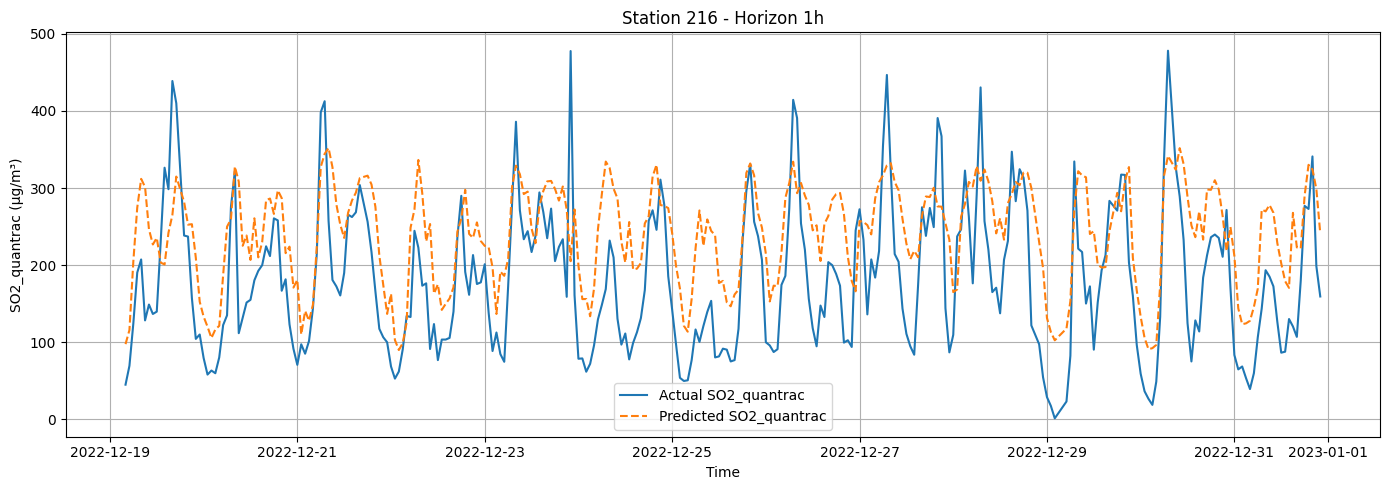

hour = 24


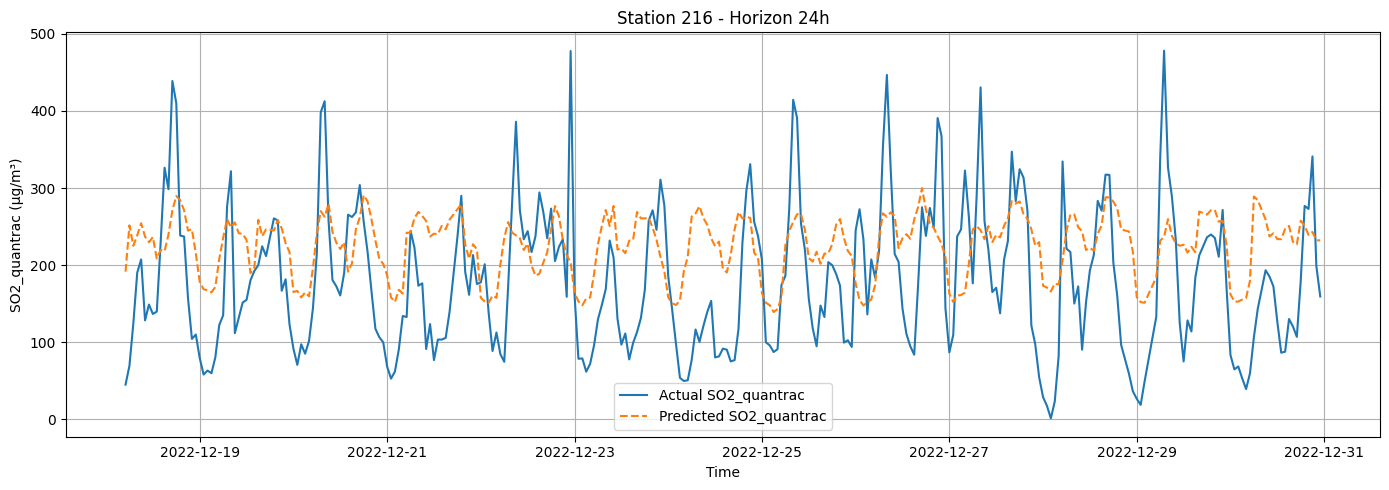

hour = 48


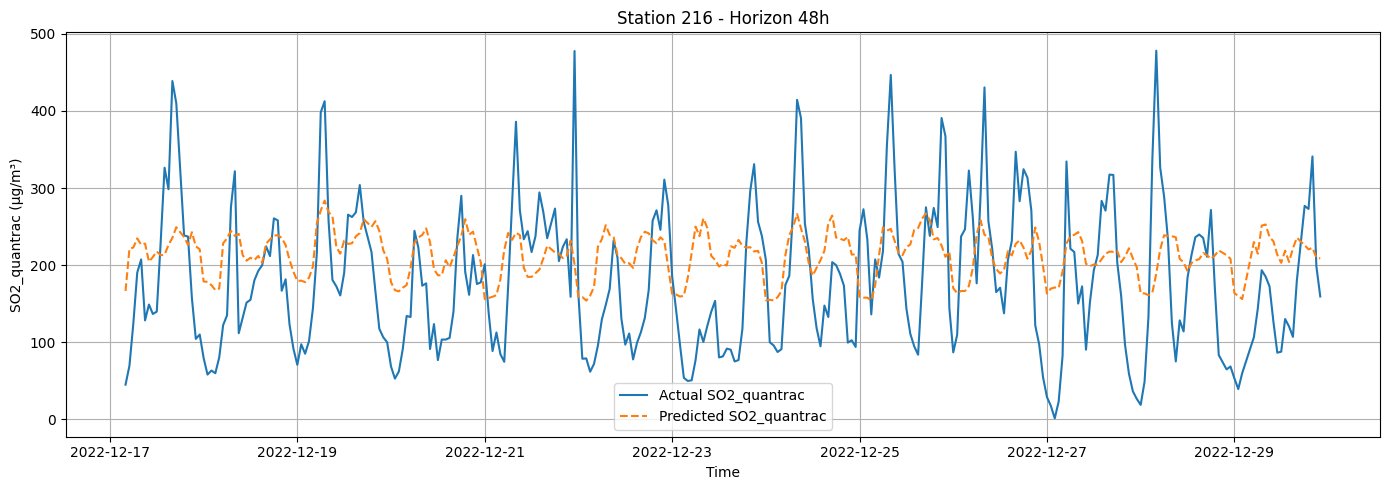

hour = 72


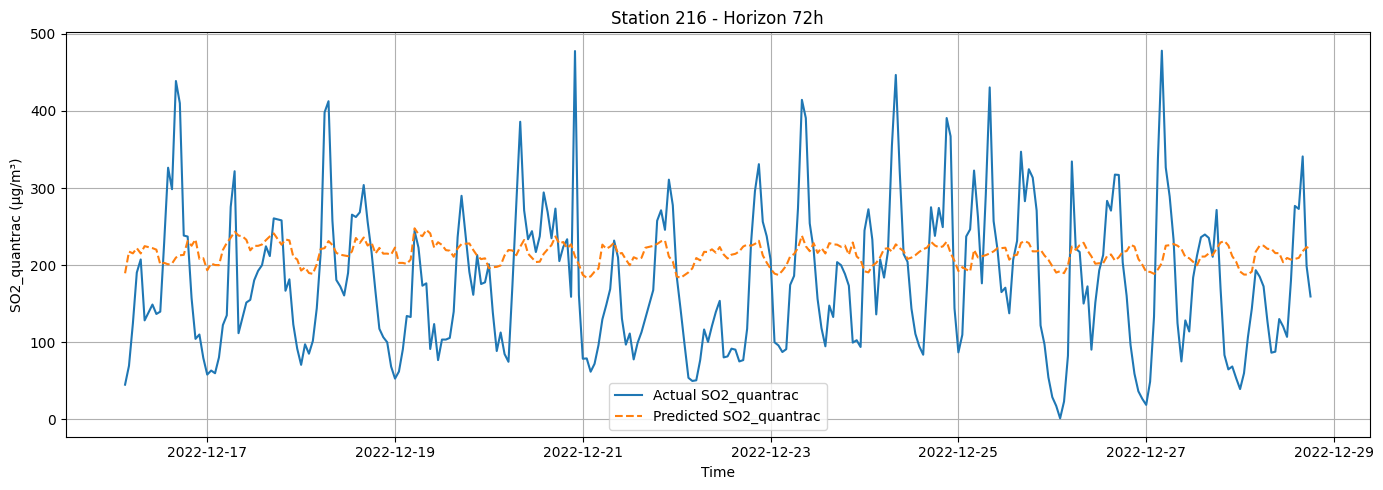

In [16]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label, LIGHTGBM_DIR=LIGHTGBM_DIR)